In [134]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam

In [135]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
x0 = 0  # Position of first boundary
x1 = 1  # Position of second boundary
L = 1 # Length of the well
n = 1 # Energy level to be found

# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [136]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(2, layer_sizes=[1, 32, 32, 1])


# The ground state energy of the particle in a box is (pi^2)/2 = 4.9348. I've initialised E to 4.0
# so that it converges to the eigenenergy quickly.
params = {'nn': nnparams, 'E': 5.5}

# Input space
x = np.linspace(x0, x1, 200)[:, None]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    # First term is the MSE, second term is used to constrain the probability to 1.
    return np.mean(diffeq**2) + (1 - prob)**2


iterList = []
diffeqList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    loss = mean + (1-prob)**2
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EList.append (float(params['E']))
    
    print ("Iteration " + str(step) + " diffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(loss) + " E = " + str(params['E']))
    print ("---------------------------------")
    

# Callback function.
def callback(params, step, g):
    if step % 100 == 0:
        objectiveDebug (params, step)

In [137]:
params = adam(grad(objective), params,
              step_size=0.001, num_iters=10001, callback=callback) 

Iteration 0 diffeq = 1723.5271191215952 prob = 3.5325060280642115
loss = 1729.9407059037767 E = 5.5
---------------------------------
Iteration 100 diffeq = 27.23968729582113 prob = 1.9009151272608773
loss = 28.051335362348613 E = 5.521969094019051
---------------------------------
Iteration 200 diffeq = 4.717116542892437 prob = 1.3847170956904016
loss = 4.865123786608894 E = 5.490778546307496
---------------------------------
Iteration 300 diffeq = 2.137611296498857 prob = 1.1753796096188118
loss = 2.168369303968904 E = 5.45645318532071
---------------------------------
Iteration 400 diffeq = 1.340722205006566 prob = 1.056581092188259
loss = 1.3439236249997821 E = 5.423138822889589
---------------------------------
Iteration 500 diffeq = 0.9044126583557025 prob = 0.9940044838938122
loss = 0.904448604569082 E = 5.39022033709638
---------------------------------
Iteration 600 diffeq = 0.6369455444350378 prob = 0.9566493373663485
loss = 0.6388248243858144 E = 5.35757242796396
-----------

Iteration 5400 diffeq = 0.003528065299722432 prob = 0.9997828542849525
loss = 0.0035281124519839957 E = 4.934818149456905
---------------------------------
Iteration 5500 diffeq = 0.0033088865707924316 prob = 0.9998007152239546
loss = 0.003308926285214395 E = 4.934805872603957
---------------------------------
Iteration 5600 diffeq = 0.038469636873435874 prob = 0.9976576053523757
loss = 0.03847512368612109 E = 4.93489777812152
---------------------------------
Iteration 5700 diffeq = 0.0029650820846388697 prob = 0.9998547261875705
loss = 0.0029651031891194473 E = 4.934838443221518
---------------------------------
Iteration 5800 diffeq = 0.0028072286531030527 prob = 0.9998708620654695
loss = 0.0028072453297091873 E = 4.934808593328063
---------------------------------
Iteration 5900 diffeq = 0.002666508852001975 prob = 0.999881943484721
loss = 0.002666522789342775 E = 4.934803139075255
---------------------------------
Iteration 6000 diffeq = 0.015477014907661322 prob = 1.0011655362162

In [138]:
print("Eigen-energy = " + str(params['E']))
print (float(params['E']))

Eigen-energy = 4.93489545365896
4.93489545365896


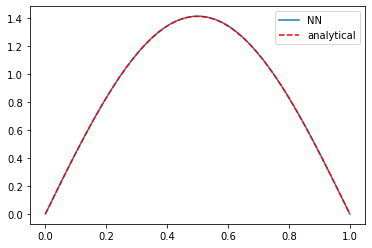

In [148]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot(x, np.sqrt(2/L) * np.sin(n*np.pi * (x-x0)/L), 'r--', label='analytical')  # Plotting the actual wavefuncion
plt.legend()
plt.savefig ('plot.png')

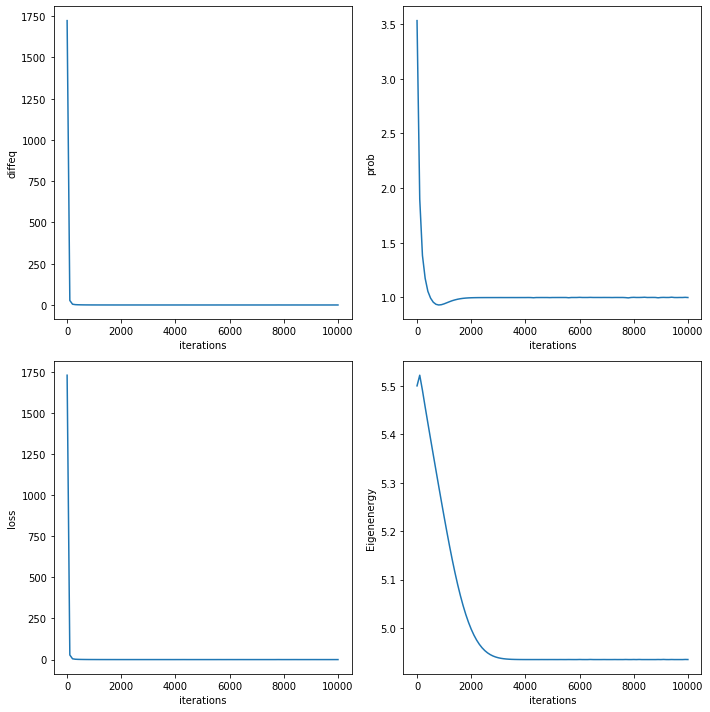

In [140]:
fig = plt.figure (figsize=(10,10))

plt.subplot (2 , 2 , 1)
plt.plot (iterList, diffeqList)
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

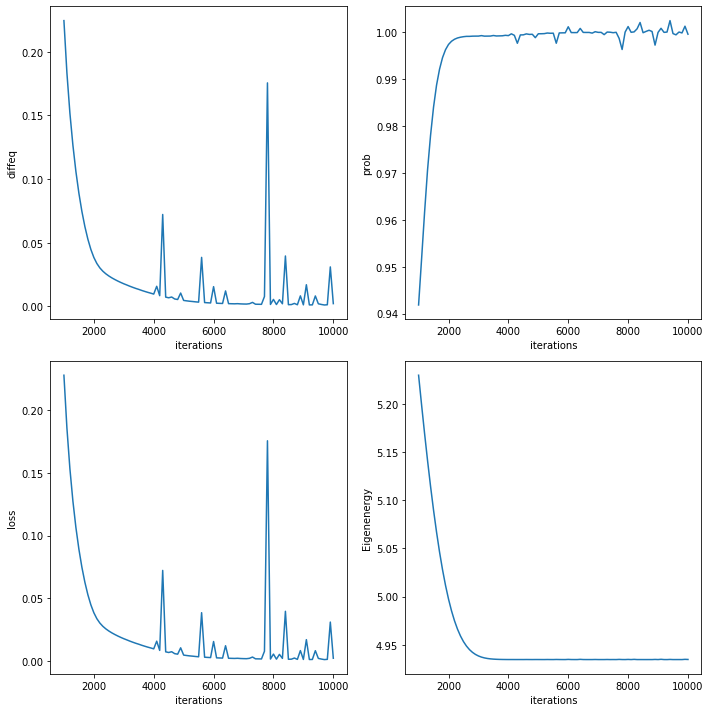

In [147]:
fig = plt.figure (figsize=(10,10))
trunc = 10

plt.subplot (2 , 2 , 1)
plt.plot (iterList[trunc:], diffeqList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList[trunc:], probList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList[trunc:], lossList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList[trunc:], EList[trunc:])
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

In [141]:
print ("\diffeq = " + str(round(diffeqList[-1],8)) + ", \prob = " + str(round(probList[-1],8)) + 
       ", \loss = " + str(round(lossList[-1],8)) + ", \eigE = " + str(round(EList[-1],8)))

\diffeq = 0.00213987, \prob = 0.99958476, \loss = 0.00214004, \eigE = 4.93489951
